# Parcels testing for ACCESS-OM2-01 output

Importing the relevant modules. The key ones are all in the `parcels` package.

In [10]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4_3D, plotTrajectoriesFile, ScipyParticle
import numpy as np
#import math
from glob import glob
from datetime import timedelta
#from operator import attrgetter
import time
#import dask.array as da
#import parcels
#print('parcels', parcels.__version__)

Reading in data from arbritrary NetCDF files¶

First, define the names of the files containing the 3D velocities. You can use wildcards (`*`) and the filenames for U, V and W can be the same.

We also need to give Parcels lat and lon data. It seems that these need to be 2D and not have any masks.

I'm not entirely sure that this is the right lat/lon to use (i.e. on the u grid), because the documentation is very vague. However for c-grid, Parcels definitely wants the dimensions of the t-grid corners, so maybe it's the same for b-grid? 

In [11]:
data_path = '/g/data/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091/'
ufiles = sorted(glob(data_path+'output196/ocean/ocean_daily_3d_u_*.nc'))
vfiles = sorted(glob(data_path+'output196/ocean/ocean_daily_3d_v_*.nc'))
wfiles = sorted(glob(data_path+'output196/ocean/ocean_daily_3d_wt_*.nc'))
mesh_mask = '/g/data/v45/akm157/model_data/for_parcels/access-om2-01_Southern_Ocean_coordinates.nc'

filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
             'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles}}

Then, define a dictionary of the variables (`U`, `V` and `W`) and dimensions (`lon`, `lat`,`depth` and `time`). I'm also guessing here that Parcels want depth on the `W` grid, because this is what it specifies for c-grid interpolation, but again there are no details on what should be supplied for b-grid interpolation...

In [12]:
variables = {'U': 'u',
             'V': 'v',
             'W': 'wt'}
dimensions = {'U': {'lon': 'geolon_c', 'lat': 'geolat_c', 'depth': 'sw_ocean', 'time': 'time'},
              'V': {'lon': 'geolon_c', 'lat': 'geolat_c', 'depth': 'sw_ocean', 'time': 'time'},
              'W': {'lon': 'geolon_c', 'lat': 'geolat_c', 'depth': 'sw_ocean', 'time': 'time'}}

Finally, read in the fieldset using the `FieldSet.from_netcdf` function with the above-defined `filenames`, `variables` and `dimensions`. 

Ideally we should also set the field_chunksize here, but I'm having memory errors whenever I try to do this.

In [13]:
fieldset = FieldSet.from_b_grid_dataset(filenames, variables, dimensions , field_chunksize=(7,300,400))

# netcdf chunksize for these files is:
# field_chunksize=(7,300,400)

We also need to add a halo for periodic zonal boundaries. This is because, if the particle is close to the edge of the fieldset (but still in it), AdvectionRK4 will need to interpolate velocities that may lay outside the fieldset domain. With the halo, we make sure AdvectionRK4 can access these values.

In [14]:
fieldset.add_constant('halo_west', fieldset.U.grid.lon[0])
fieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])

fieldset.add_periodic_halo(zonal=True)

The other item we need is a custom Kernel that can move the particle from one side of the domain to the other.

In [15]:
def periodicBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle.lon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle.lon -= fieldset.halo_east - fieldset.halo_west

Now define a `ParticleSet`, in this case particles starting on a line at the end of the Drygalski Trough in the Ross Sea, using the `ParticleSet.from_line` constructor method.

In [16]:
pset = ParticleSet.from_line(fieldset=fieldset, 
                             pclass=JITParticle,
                             size=50,
                             start=(-187.3, -72.15),
                             finish=(-186.3, -72.4),
                             depth=500)

Print out the starting locations of the particles:

In [17]:
#print(pset)

And finally execute the `ParticleSet` for 2 days using 4th order Runge-Kutta in 3D. I'm also having memory issues here when I run for too long.

In [18]:
output_file = pset.ParticleFile(name="AntarcticParticles.nc", 
                                outputdt=timedelta(days=1)) # the file name and the time step of the outputs
tic = time.time()
pset.execute(AdvectionRK4_3D + pset.Kernel(periodicBC),   # the kernel (which defines how particles move)
             runtime=timedelta(days=4),    # the total length of the run
             dt=timedelta(hours=2),      # the timestep of the kernel
             output_file=output_file)
time_taken = time.time()-tic
print(time_taken)

INFO: Compiled JITParticleAdvectionRK4_3DperiodicBC ==> /local/v45/akm157/tmp/parcels-5847/8f9352fe4c70f4a2f06d8c44a070e7e3_0.so
INFO: Temporary output files are stored in out-AEGKYXOK.
INFO: You can use "parcels_convert_npydir_to_netcdf out-AEGKYXOK" to convert these to a NetCDF file during the run.
100% (345600.0 of 345600.0) |############| Elapsed Time: 0:01:03 Time:  0:01:03


187.02147579193115


Print out particle locations after advecting to check it worked:

In [19]:
#print(pset)

Plot trajectories using Parcels plotting tool:

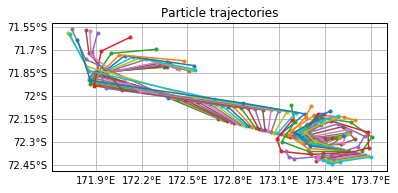

In [20]:
output_file.export()  # export the trajectory data to a netcdf file
plotTrajectoriesFile('AntarcticParticles.nc');

Plot trajectories manually:

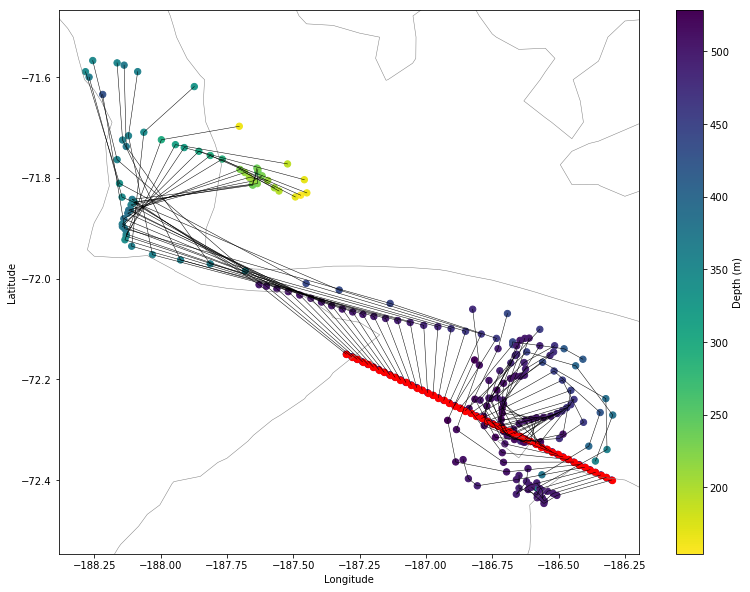

In [21]:
import netCDF4
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#output_file.export()  # export the trajectory data to a netcdf file

# load data from the output file:
ncfile = netCDF4.Dataset("AntarcticParticles.nc")
x = ncfile.variables["lon"][:].squeeze()
y = ncfile.variables["lat"][:].squeeze()
z = ncfile.variables["z"][:].squeeze()

fig = plt.figure(figsize=(13,10))
for particle in range(x.shape[0]):
    plt.plot(x[particle,:], y[particle,:],'k',linewidth=0.5,zorder=2)
cb = plt.scatter(x, y, c=z,s=40, marker="o",zorder=1,cmap='viridis_r')
plt.ylabel("Latitude")
cbar = plt.colorbar()
cbar.set_label('Depth (m)')

# starting locations:
plt.scatter(x[:,0], y[:,0], c='r',s=40, marker="o",zorder=1)
plt.xlabel("Longitude")

# load topography:
grid_file = '/g/data/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091/'+\
    'output196/ocean/ocean_grid.nc'
ncfile = netCDF4.Dataset(grid_file)
topo = ncfile.variables["ht"][:900,:]
xt_ocean = ncfile.variables["xt_ocean"][...]
yt_ocean = ncfile.variables["yt_ocean"][:900]
plt.contour(xt_ocean,yt_ocean,topo,[500,1000,2000,3000],colors='gray',linewidths=0.5)

plt.ylim((y.min()-.1,y.max()+.1))
plt.xlim((x.min()-.1,x.max()+.1))
plt.show()